# Freesound Transient Downloader & Trimmer

This notebook downloads CC0-licensed percussive transients from Freesound and trims them to short attack samples (5-30ms) for use in the hybrid sample+synthesis approach.

## Setup
1. Get a Freesound API key at https://freesound.org/apiv2/apply/
2. Set your API key below

In [31]:
# Install required packages
!pip install freesound-python requests pydub numpy scipy librosa soundfile


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import os
import requests
import numpy as np
from pathlib import Path
import json

# Configuration
FREESOUND_API_KEY = "FW26Ykh19VlJY0pkP0hN983HTnhI4MEZPMzCTY1v"
OUTPUT_DIR = Path(r"c:\Users\chpa9007\Downloads\generativemusic\SampleTransients")
OUTPUT_DIR.mkdir(exist_ok=True)

# Target sample rate and transient duration
TARGET_SR = 48000
TRANSIENT_MS = 20  # milliseconds of attack to keep

print(f"Output directory: {OUTPUT_DIR}")
print(f"Target: {TRANSIENT_MS}ms transients at {TARGET_SR}Hz")

Output directory: c:\Users\chpa9007\Downloads\generativemusic\SampleTransients
Target: 20ms transients at 48000Hz


In [51]:
import librosa
import soundfile as sf
from scipy import signal
from scipy.ndimage import uniform_filter1d

def download_sound(sound_id: int, api_key: str, output_path: Path) -> bool:
    """Download a sound from Freesound by ID. Tries full file first, falls back to preview."""
    # Get sound info
    info_url = f"https://freesound.org/apiv2/sounds/{sound_id}/"
    headers = {"Authorization": f"Token {api_key}"}
    
    resp = requests.get(info_url, headers=headers)
    if resp.status_code != 200:
        print(f"Failed to get info for sound {sound_id}: {resp.status_code}")
        return False
    
    info = resp.json()
    
    # Try to download the full original file first (avoids trimmed previews)
    download_url = info.get('download')
    if download_url:
        audio_resp = requests.get(download_url, headers=headers)
        if audio_resp.status_code == 200:
            # Determine extension from content-type or URL
            content_type = audio_resp.headers.get('Content-Type', '')
            if 'wav' in content_type or 'wav' in download_url:
                ext = '.wav'
            elif 'flac' in content_type or 'flac' in download_url:
                ext = '.flac'
            elif 'aiff' in content_type or 'aif' in download_url:
                ext = '.aiff'
            else:
                ext = '.wav'  # default
            temp_path = output_path.with_suffix(ext)
            temp_path.write_bytes(audio_resp.content)
            return temp_path
    
    # Fall back to preview if full file download failed
    preview_url = info.get('previews', {}).get('preview-hq-ogg')
    if not preview_url:
        preview_url = info.get('previews', {}).get('preview-hq-mp3')
    
    if not preview_url:
        print(f"No download available for {sound_id}")
        return False
    
    # Download preview
    audio_resp = requests.get(preview_url)
    if audio_resp.status_code != 200:
        print(f"Failed to download {sound_id}")
        return False
    
    # Save temporarily
    ext = '.ogg' if 'ogg' in preview_url else '.mp3'
    temp_path = output_path.with_suffix(ext)
    temp_path.write_bytes(audio_resp.content)
    
    return temp_path


def analyze_transient_end(y: np.ndarray, sr: int, onset_sample: int, 
                          method: str = "envelope", 
                          decay_threshold: float = 0.3,
                          min_ms: float = 5, max_ms: float = 150) -> int:
    """
    Analyze audio to find where the transient ends and sustain/decay begins.
    
    Methods:
    - "envelope": Find where amplitude drops to decay_threshold of peak
    - "spectral": Find where spectral flux drops (high flux = transient)
    - "derivative": Find where energy derivative goes negative (attack ended)
    
    Returns: sample index where transient ends
    """
    min_samples = int((min_ms / 1000) * sr)
    max_samples = int((max_ms / 1000) * sr)
    
    # Get audio from onset
    audio_from_onset = y[onset_sample:onset_sample + max_samples]
    if len(audio_from_onset) < min_samples:
        return onset_sample + len(audio_from_onset)
    
    if method == "envelope":
        # Compute amplitude envelope with smoothing
        envelope = np.abs(audio_from_onset)
        # Smooth with ~2ms window
        window_size = max(1, int(0.002 * sr))
        envelope_smooth = uniform_filter1d(envelope, size=window_size)
        
        # Find peak
        peak_idx = np.argmax(envelope_smooth)
        peak_val = envelope_smooth[peak_idx]
        
        if peak_val == 0:
            return onset_sample + min_samples
        
        # Find where envelope drops below threshold of peak
        threshold = peak_val * decay_threshold
        
        # Search after peak
        post_peak = envelope_smooth[peak_idx:]
        below_threshold = np.where(post_peak < threshold)[0]
        
        if len(below_threshold) > 0:
            end_idx = peak_idx + below_threshold[0]
        else:
            end_idx = len(envelope_smooth)
        
        # Clamp to min/max
        end_idx = max(min_samples, min(end_idx, max_samples))
        return onset_sample + end_idx
    
    elif method == "spectral":
        # Use spectral flux - high flux during transient
        hop_length = 256
        n_fft = 1024
        
        # Compute spectrogram
        S = np.abs(librosa.stft(audio_from_onset, n_fft=n_fft, hop_length=hop_length))
        
        # Spectral flux (sum of positive differences)
        flux = np.sum(np.maximum(0, np.diff(S, axis=1)), axis=0)
        
        if len(flux) < 2:
            return onset_sample + min_samples
        
        # Smooth flux
        flux_smooth = uniform_filter1d(flux, size=3)
        
        # Find where flux drops below threshold of max
        flux_threshold = np.max(flux_smooth) * 0.2
        below = np.where(flux_smooth < flux_threshold)[0]
        
        if len(below) > 0 and below[0] > 0:
            end_frame = below[0]
        else:
            end_frame = len(flux_smooth)
        
        end_sample = end_frame * hop_length
        end_sample = max(min_samples, min(end_sample, max_samples))
        return onset_sample + end_sample
    
    elif method == "derivative":
        # Energy derivative - transient ends when energy stops increasing
        hop_length = 128
        
        # Compute RMS energy
        rms = librosa.feature.rms(y=audio_from_onset, hop_length=hop_length)[0]
        
        if len(rms) < 3:
            return onset_sample + min_samples
        
        # Smooth RMS
        rms_smooth = uniform_filter1d(rms, size=3)
        
        # Find where derivative goes from positive to negative (peak of attack)
        derivative = np.diff(rms_smooth)
        
        # Find first significant negative derivative after initial rise
        peak_idx = np.argmax(rms_smooth)
        
        # Find where derivative becomes consistently negative
        post_peak_deriv = derivative[peak_idx:]
        negative_run = 0
        end_frame = peak_idx
        
        for i, d in enumerate(post_peak_deriv):
            if d < 0:
                negative_run += 1
                if negative_run >= 3:  # 3 consecutive negative = decay starting
                    end_frame = peak_idx + i - 2
                    break
            else:
                negative_run = 0
        
        end_sample = end_frame * hop_length
        end_sample = max(min_samples, min(end_sample, max_samples))
        return onset_sample + end_sample
    
    return onset_sample + min_samples


def trim_to_transient(input_path: Path, output_path: Path, duration_ms: float = 20, target_sr: int = 48000):
    """Load audio, find onset, and trim to FIXED attack transient (legacy - uses fixed duration)."""
    # Load audio
    y, sr = librosa.load(input_path, sr=target_sr, mono=True)
    
    # Find onset (attack start)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='samples')
    
    if len(onset_frames) == 0:
        # No clear onset, use start after silence
        onset_sample = np.argmax(np.abs(y) > 0.01 * np.max(np.abs(y)))
    else:
        onset_sample = onset_frames[0]
    
    # Calculate samples for duration
    duration_samples = int((duration_ms / 1000) * target_sr)
    
    # Extract transient with small pre-onset padding
    pre_samples = int(0.001 * target_sr)  # 1ms before onset
    start = max(0, onset_sample - pre_samples)
    end = min(len(y), start + duration_samples + pre_samples)
    
    transient = y[start:end]
    
    # Apply quick fade out to avoid clicks
    fade_samples = min(len(transient) // 4, int(0.005 * target_sr))  # 5ms or 1/4 of length
    if fade_samples > 0:
        fade = np.linspace(1, 0, fade_samples)
        transient[-fade_samples:] *= fade
    
    # Normalize
    if np.max(np.abs(transient)) > 0:
        transient = transient / np.max(np.abs(transient)) * 0.95
    
    # Save as WAV
    sf.write(output_path, transient, target_sr, subtype='PCM_16')
    
    return len(transient) / target_sr * 1000  # return duration in ms


def extract_smart_transient(input_path: Path, output_path: Path, 
                            target_sr: int = 48000,
                            method: str = "envelope",
                            decay_threshold: float = 0.3,
                            min_ms: float = 5, max_ms: float = 150):
    """
    Extract the TRUE transient by analyzing the sound envelope/spectrum.
    
    Args:
        input_path: Source audio file
        output_path: Where to save the transient
        target_sr: Sample rate
        method: "envelope", "spectral", or "derivative"
        decay_threshold: For envelope method - what fraction of peak to cut at (0.3 = 30%)
        min_ms: Minimum transient length
        max_ms: Maximum transient length
    
    Returns:
        dict with duration_ms, onset_ms, method used
    """
    # Load audio
    y, sr = librosa.load(input_path, sr=target_sr, mono=True)
    
    # Find onset
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='samples')
    
    if len(onset_frames) == 0:
        onset_sample = np.argmax(np.abs(y) > 0.01 * np.max(np.abs(y)))
    else:
        onset_sample = onset_frames[0]
    
    # Analyze to find transient end
    transient_end = analyze_transient_end(
        y, sr, onset_sample, 
        method=method, 
        decay_threshold=decay_threshold,
        min_ms=min_ms, 
        max_ms=max_ms
    )
    
    # Extract with 1ms pre-onset padding
    pre_samples = int(0.001 * target_sr)
    start = max(0, onset_sample - pre_samples)
    end = min(len(y), transient_end)
    
    transient = y[start:end]
    
    # Apply fade out (5ms or 10% of length, whichever is smaller)
    fade_samples = min(len(transient) // 10, int(0.005 * target_sr))
    if fade_samples > 0:
        fade = np.linspace(1, 0, fade_samples)
        transient[-fade_samples:] *= fade
    
    # Normalize
    if np.max(np.abs(transient)) > 0:
        transient = transient / np.max(np.abs(transient)) * 0.95
    
    # Save
    sf.write(output_path, transient, target_sr, subtype='PCM_16')
    
    duration_ms = len(transient) / target_sr * 1000
    onset_ms = onset_sample / target_sr * 1000
    
    return {
        "duration_ms": duration_ms,
        "onset_ms": onset_ms,
        "method": method,
        "start_sample": start,
        "end_sample": end
    }

print("Functions defined!")
print("  - trim_to_transient(): Fixed duration (legacy)")
print("  - extract_smart_transient(): Analyzes envelope/spectrum to find true transient")
print("    Methods: 'envelope' (amplitude decay), 'spectral' (flux), 'derivative' (energy)")

Functions defined!
  - trim_to_transient(): Fixed duration (legacy)
  - extract_smart_transient(): Analyzes envelope/spectrum to find true transient
    Methods: 'envelope' (amplitude decay), 'spectral' (flux), 'derivative' (energy)


In [34]:
import re

def search_freesound(query: str, api_key: str, max_results: int = 10, max_duration: float = 5.0) -> list:
    """Search Freesound for sounds matching query."""
    search_url = "https://freesound.org/apiv2/search/text/"
    headers = {"Authorization": f"Token {api_key}"}
    
    params = {
        "query": query,
        "fields": "id,name,duration,license,previews,tags,description,username",
        "page_size": max_results,
        "sort": "rating_desc"
    }
    
    resp = requests.get(search_url, headers=headers, params=params)
    if resp.status_code != 200:
        print(f"Search failed: {resp.status_code} - {resp.text}")
        return []
    
    data = resp.json()
    results = data.get('results', [])
    
    # Filter to sounds under 5 seconds to avoid loops
    short_sounds = [s for s in results if s.get('duration', 999) < max_duration]
    
    return short_sounds

def extract_notes(tags: list, name: str = "") -> list:
    """Extract musical note information from tags AND name."""
    notes = []
    
    # Patterns to match notes like: C4, A#3, Bb2, F#5, etc.
    # Also matches: C-4, note_C4, note-c4, _C4_, etc.
    note_patterns = [
        re.compile(r'\b([A-Ga-g])([#b]?)(\d)\b'),  # Word boundary: C4, A#3
        re.compile(r'[-_]([A-Ga-g])([#b]?)(\d)[-_\.]', re.I),  # Surrounded: _C4_, -A3-
        re.compile(r'note[-_]?([A-Ga-g])([#b]?)[-_]?(\d)', re.I),  # note-c4, note_C4
    ]
    
    # Check in tags
    for tag in tags:
        for pat in note_patterns:
            for match in pat.finditer(tag):
                note_name = match.group(1).upper()
                accidental = match.group(2) or ""
                octave = int(match.group(3))
                note_str = f"{note_name}{accidental}{octave}"
                if not any(n['note'] == note_str for n in notes):
                    notes.append({
                        "note": note_str,
                        "name": note_name,
                        "accidental": accidental,
                        "octave": octave,
                        "source": "tag"
                    })
    
    # Check in name (often has note info like "Kalimba C3" or "vibraphone_A4_soft")
    if name:
        for pat in note_patterns:
            for match in pat.finditer(name):
                note_name = match.group(1).upper()
                accidental = match.group(2) or ""
                octave = int(match.group(3))
                note_str = f"{note_name}{accidental}{octave}"
                if not any(n['note'] == note_str for n in notes):
                    notes.append({
                        "note": note_str,
                        "name": note_name,
                        "accidental": accidental,
                        "octave": octave,
                        "source": "name"
                    })
    
    return notes

# Simpler approach: one query per instrument, download multiple samples
INSTRUMENTS = [
    "kalimba",
    "mbira", 
    "thumb piano",
    "handpan",
    "hang drum",
    "tongue drum",
    "tank drum",
    "vibraphone",
    "marimba",
    "glockenspiel",
    "xylophone",
    "metallophone",
    "celesta",
    "gamelan",
    "rhodes",
    "rhodes piano"
    "fender rhodes",
    "electric piano",
]

print(f"Will search for {len(INSTRUMENTS)} instrument types")

Will search for 17 instrument types


In [35]:
def download_instrument_samples(instrument: str, api_key: str, output_dir: Path, 
                                  max_samples: int = 10, transient_ms: float = 20):
    """Download and process sounds for an instrument. Saves metadata with tags and notes."""
    # Normalize instrument name for folder
    folder_name = instrument.replace(' ', '_').lower()
    category_dir = output_dir / folder_name
    category_dir.mkdir(parents=True, exist_ok=True)
    
    processed = []
    all_metadata = []
    
    print(f"  Searching: {instrument}")
    sounds = search_freesound(instrument, api_key, max_results=max_samples, max_duration=5.0)
    print(f"  Found {len(sounds)} sounds under 5 seconds")
    
    for sound in sounds:
        sound_id = sound['id']
        original_name = sound['name']
        name = original_name.replace(' ', '_').replace('/', '_')[:30]
        tags = sound.get('tags', [])
        
        # Extract note information from tags AND name
        notes = extract_notes(tags, original_name)
        
        output_name = f"{sound_id}_{name}.wav"
        output_path = category_dir / output_name
        
        # Prepare metadata
        metadata = {
            "id": sound_id,
            "name": original_name,
            "filename": output_name,
            "tags": tags,
            "notes": notes,
            "instrument": instrument,
            "username": sound.get('username', ''),
            "duration_original": sound.get('duration', 0),
            "license": sound.get('license', ''),
        }
        
        if output_path.exists():
            print(f"    Already exists: {output_name}")
            all_metadata.append(metadata)
            continue
        
        print(f"    Downloading: {original_name} (ID: {sound_id}, {sound.get('duration', 0):.1f}s)")
        if notes:
            print(f"      Notes: {[n['note'] for n in notes]}")
        
        # Download
        temp_path = download_sound(sound_id, api_key, output_path)
        if not temp_path:
            continue
        
        try:
            # Trim to transient
            duration = trim_to_transient(temp_path, output_path, transient_ms)
            metadata['duration_trimmed_ms'] = duration
            print(f"    Saved: {output_name} ({duration:.1f}ms)")
            processed.append(str(output_path))
            all_metadata.append(metadata)
            
            # Clean up temp file
            if temp_path != output_path:
                temp_path.unlink()
                
        except Exception as e:
            print(f"    Error processing: {e}")
            if temp_path.exists():
                temp_path.unlink()
    
    # Save metadata JSON for this instrument
    if all_metadata:
        metadata_path = category_dir / "metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(all_metadata, f, indent=2)
        print(f"  Saved metadata: {metadata_path}")
    
    return processed, all_metadata

print("Download function ready!")

Download function ready!


In [39]:
# Main execution - Download samples for all instruments

if FREESOUND_API_KEY == "YOUR_API_KEY_HERE":
    print("⚠️  Please set your Freesound API key in cell 3!")
    print("Get one at: https://freesound.org/apiv2/apply/")
else:
    all_processed = []
    all_metadata = []
    
    for instrument in INSTRUMENTS:
        print(f"\n{'='*50}")
        print(f"Processing: {instrument}")
        print('='*50)
        
        files, metadata = download_instrument_samples(
            instrument=instrument,
            api_key=FREESOUND_API_KEY,
            output_dir=OUTPUT_DIR,
            max_samples=10,  # Get up to 10 samples per instrument
            transient_ms=TRANSIENT_MS
        )
        all_processed.extend(files)
        all_metadata.extend(metadata)
    
    # Save master metadata file
    master_metadata_path = OUTPUT_DIR / "all_samples.json"
    with open(master_metadata_path, 'w') as f:
        json.dump(all_metadata, f, indent=2)
    
    # Summary of notes found
    samples_with_notes = [m for m in all_metadata if m.get('notes')]
    
    print(f"\n{'='*50}")
    print(f"✅ Done! Downloaded {len(all_processed)} transient samples to:")
    print(f"   {OUTPUT_DIR}")
    print(f"\n📝 Metadata saved to: {master_metadata_path}")
    print(f"🎵 Samples with note info: {len(samples_with_notes)} / {len(all_metadata)}")


Processing: kalimba
  Searching: kalimba
  Found 5 sounds under 5 seconds
    Already exists: 536551_Kalimba_C1.wav
    Already exists: 536549_Kalimba_C3.wav
    Already exists: 6998_KLMB_e5.wav.wav
    Already exists: 6996_KLMB_d4.wav.wav
    Already exists: 58736_Kalimba_Lam10(C4)_Wipe(Med).wa.wav
  Saved metadata: c:\Users\chpa9007\Downloads\generativemusic\SampleTransients\kalimba\metadata.json

Processing: mbira
  Searching: mbira
  Found 6 sounds under 5 seconds
    Already exists: 536551_Kalimba_C1.wav
    Already exists: 536549_Kalimba_C3.wav
    Already exists: 58736_Kalimba_Lam10(C4)_Wipe(Med).wa.wav
    Already exists: 441137_Kalimba_E5.wav.wav
    Already exists: 181738_b'_mf_sansula.WAV.wav
    Already exists: 58732_Kalimba_Lam08(A3)_Wipe(Med).wa.wav
  Saved metadata: c:\Users\chpa9007\Downloads\generativemusic\SampleTransients\mbira\metadata.json

Processing: thumb piano
  Searching: thumb piano
  Found 7 sounds under 5 seconds
    Already exists: 536551_Kalimba_C1.wav
 

KeyboardInterrupt: 

In [37]:
# Debug: Search for specific user's samples (e.g., hollandm's kalimba)
# This helps understand why certain samples weren't found

if FREESOUND_API_KEY != "YOUR_API_KEY_HERE":
    search_url = "https://freesound.org/apiv2/search/text/"
    headers = {"Authorization": f"Token {FREESOUND_API_KEY}"}
    
    # Search for hollandm's kalimba samples specifically
    params = {
        "query": "kalimba",
        "filter": "username:hollandm",
        "fields": "id,name,duration,license,tags,username",
        "page_size": 30,
        "sort": "rating_desc"
    }
    
    resp = requests.get(search_url, headers=headers, params=params)
    if resp.status_code == 200:
        data = resp.json()
        results = data.get('results', [])
        
        print(f"Found {len(results)} kalimba samples from hollandm:")
        print("="*70)
        
        for s in results:
            duration = s.get('duration', 0)
            filtered_out = " ⚠️ >5s FILTERED" if duration > 5.0 else " ✅ would be included"
            notes = extract_notes(s.get('tags', []), s.get('name', ''))
            note_str = f" Notes: {[n['note'] for n in notes]}" if notes else ""
            
            print(f"ID: {s['id']:6} | {duration:5.2f}s | {s['name'][:45]}")
            print(f"         {filtered_out}{note_str}")
            print(f"         Tags: {', '.join(s.get('tags', [])[:8])}")
            print()
    else:
        print(f"Search failed: {resp.status_code} - {resp.text}")

Found 30 kalimba samples from hollandm:
ID: 691791 |  2.50s | D5 soft - kalimba
          ✅ would be included Notes: ['D5']
         Tags: african, d5, instrument, kalimba, mbira, metal, musical-instrument, plucked

ID: 691787 |  2.50s | D3 soft - kalimba
          ✅ would be included Notes: ['D3']
         Tags: african, d3, instrument, kalimba, mbira, metal, musical-instrument, plucked

ID: 691773 |  2.50s | A3 soft - kalimba
          ✅ would be included Notes: ['A3']
         Tags: a3, african, instrument, kalimba, mbira, metal, plink, thumb-piano

ID: 691802 |  2.50s | G3 hard - kalimba
          ✅ would be included Notes: ['G3']
         Tags: african, g3, instrument, kalimba, mbira, metal, musical-instrument, plucked

ID: 691798 |  2.50s | F3 hard - kalimba
          ✅ would be included Notes: ['F3']
         Tags: african, f3, instrument, kalimba, mbira, metal, musical-instrument, plucked

ID: 691784 |  2.50s | C5 hard - kalimba
          ✅ would be included Notes: ['C5']
     

In [45]:
# Improved search: Remove duration filter since we trim anyway
# Also use "single note" and "one shot" variants for better results
# SAVES BOTH: full files in /full subfolder + trimmed transients

import shutil

def search_freesound_improved(query: str, api_key: str, max_results: int = 15) -> list:
    """Search Freesound without duration filter - we trim to transients anyway."""
    search_url = "https://freesound.org/apiv2/search/text/"
    headers = {"Authorization": f"Token {api_key}"}
    
    params = {
        "query": query,
        "fields": "id,name,duration,license,previews,tags,description,username",
        "page_size": max_results,
        "sort": "rating_desc"
    }
    
    resp = requests.get(search_url, headers=headers, params=params)
    if resp.status_code != 200:
        print(f"Search failed: {resp.status_code}")
        return []
    
    return resp.json().get('results', [])

# Better queries: use "single note" or "one shot" variants
# Skip glockenspiel - already done or not needed
IMPROVED_QUERIES = [
    ("kalimba", ["kalimba single note", "kalimba note", "kalimba"]),
    ("mbira", ["mbira single note", "mbira note", "mbira"]),
    ("thumb_piano", ["thumb piano single", "thumb piano note"]),
    ("handpan", ["handpan single note", "handpan hit", "handpan"]),
    ("hang_drum", ["hang drum note", "hang drum hit"]),
    ("tongue_drum", ["tongue drum single", "tongue drum note", "tongue drum"]),
    ("tank_drum", ["tank drum note", "steel tongue drum"]),
    ("vibraphone", ["vibraphone single note", "vibraphone note", "vibes note"]),
    ("marimba", ["marimba single note", "marimba note"]),
    # ("glockenspiel", ["glockenspiel note", "glockenspiel single"]),  # SKIPPED
    ("xylophone", ["xylophone single note", "xylophone note"]),
    ("metallophone", ["metallophone note", "metal bar", "chime bar"]),
    ("celesta", ["celesta note", "celeste note", "celesta single"]),
    ("gamelan", ["gamelan note", "gamelan single", "bonang"]),
    ("rhodes", ["rhodes single note", "rhodes note", "fender rhodes note"]),
    ("electric_piano", ["electric piano note", "wurlitzer note", "ep note"]),
]

# Download with improved queries - SAVE BOTH FULL + TRANSIENTS
all_improved = []
all_improved_meta = []

for folder_name, queries in IMPROVED_QUERIES:
    category_dir = OUTPUT_DIR / folder_name
    category_dir.mkdir(parents=True, exist_ok=True)
    
    # Create "full" subfolder for complete audio files
    full_dir = category_dir / "full"
    full_dir.mkdir(exist_ok=True)
    
    seen_ids = set()
    collected = []
    
    # Try each query variant - only collect samples with note info
    for query in queries:
        if len(collected) >= 200:
            break
        results = search_freesound_improved(query, FREESOUND_API_KEY, max_results=150)
        for s in results:
            if s['id'] not in seen_ids and len(collected) < 200:
                # Check if it has note info before collecting
                notes = extract_notes(s.get('tags', []), s.get('name', ''))
                if notes:
                    seen_ids.add(s['id'])
                    s['_notes'] = notes  # Cache the notes
                    collected.append(s)
    
    print(f"\n{'='*50}")
    print(f"📁 {folder_name}: found {len(collected)} unique samples")
    
    folder_meta = []
    for sound in collected:
        sound_id = sound['id']
        notes = sound.get('_notes', [])  # Use cached notes from collection
        original_name = sound['name']
        name = original_name.replace(' ', '_').replace('/', '_')[:30]
        tags = sound.get('tags', [])
        
        output_name = f"{sound_id}_{name}.wav"
        transient_path = category_dir / output_name  # Trimmed transient in main folder
        full_path = full_dir / output_name  # Full file in /full subfolder
        
        metadata = {
            "id": sound_id,
            "name": original_name,
            "filename": output_name,
            "full_file": f"full/{output_name}",
            "tags": tags,
            "notes": notes,
            "instrument": folder_name,
            "username": sound.get('username', ''),
            "duration_original": sound.get('duration', 0),
            "license": sound.get('license', ''),
        }
        
        # Skip if full file already exists (don't re-download)
        if full_path.exists():
            print(f"  ✓ Full file exists: {output_name}")
            folder_meta.append(metadata)
            continue
        
        note_str = f" [{', '.join(n['note'] for n in notes)}]"
        print(f"  ↓ {original_name[:40]}{note_str}")
        
        temp_path = download_sound(sound_id, FREESOUND_API_KEY, transient_path)
        if not temp_path:
            continue
        
        try:
            # 1. Save FULL file (convert to WAV at target sample rate)
            y, sr = librosa.load(temp_path, sr=TARGET_SR, mono=True)
            # Normalize full file
            if np.max(np.abs(y)) > 0:
                y = y / np.max(np.abs(y)) * 0.95
            sf.write(full_path, y, TARGET_SR, subtype='PCM_16')
            full_duration_ms = len(y) / TARGET_SR * 1000
            metadata['full_duration_ms'] = full_duration_ms
            print(f"    📦 Full: {full_duration_ms:.0f}ms")
            
            # 2. Extract SMART transient (analyzes envelope to find true attack end)
            trans_info = extract_smart_transient(
                temp_path, transient_path, 
                target_sr=TARGET_SR,
                method="envelope",  # or "spectral", "derivative"
                decay_threshold=0.3,  # cut when amplitude drops to 30% of peak
                min_ms=5,   # at least 5ms
                max_ms=150  # at most 150ms
            )
            metadata['duration_trimmed_ms'] = trans_info['duration_ms']
            metadata['transient_method'] = trans_info['method']
            print(f"    ✂️  Transient: {trans_info['duration_ms']:.1f}ms (analyzed)")
            
            all_improved.append(str(transient_path))
            folder_meta.append(metadata)
            
            # Clean up temp file (original downloaded format)
            if temp_path != transient_path and temp_path.exists():
                temp_path.unlink()
                
        except Exception as e:
            print(f"    Error: {e}")
            if temp_path.exists():
                temp_path.unlink()
    
    # Save metadata
    if folder_meta:
        all_improved_meta.extend(folder_meta)
        with open(category_dir / "metadata.json", 'w') as f:
            json.dump(folder_meta, f, indent=2)

# Save master metadata
with open(OUTPUT_DIR / "all_samples.json", 'w') as f:
    json.dump(all_improved_meta, f, indent=2)

samples_with_notes = [m for m in all_improved_meta if m.get('notes')]
print(f"\n{'='*50}")
print(f"✅ Downloaded {len(all_improved)} samples")
print(f"📦 Full files saved in: <instrument>/full/")
print(f"✂️  Transients saved in: <instrument>/")
print(f"📊 Total samples with notes: {len(samples_with_notes)} / {len(all_improved_meta)}")


📁 kalimba: found 40 unique samples
  ✓ Full file exists: 536551_Kalimba_C1.wav
  ✓ Full file exists: 536549_Kalimba_C3.wav
  ✓ Full file exists: 441133_Kalimba_B4.wav.wav
  ✓ Full file exists: 536550_Kalimba_C2.wav
  ✓ Full file exists: 691791_D5_soft_-_kalimba.wav
  ✓ Full file exists: 441135_Kalimba_A4.wav.wav
  ✓ Full file exists: 691787_D3_soft_-_kalimba.wav
  ✓ Full file exists: 441136_Kalimba_A3.wav.wav
  ✓ Full file exists: 441134_Kalimba_B3.wav.wav
  ✓ Full file exists: 6998_KLMB_e5.wav.wav
  ✓ Full file exists: 6996_KLMB_d4.wav.wav
  ✓ Full file exists: 58736_Kalimba_Lam10(C4)_Wipe(Med).wa.wav
  ✓ Full file exists: 6997_KLMB_e4.wav.wav
  ✓ Full file exists: 70675_SanzAnais_79_G4_mezzopiano.aif.wav
  ✓ Full file exists: 441137_Kalimba_E5.wav.wav
  ✓ Full file exists: 398967_kalimba_b9_06.flac.wav
  ✓ Full file exists: 58732_Kalimba_Lam08(A3)_Wipe(Med).wa.wav
  ✓ Full file exists: 398971_kalimba_b9_07.flac.wav
  ✓ Full file exists: 70673_SanzAnais_79_G4_forte.aif.wav
  ✓ Full f

In [22]:
# List what we have with metadata
import glob

print("Downloaded transients by instrument:")
print("="*60)

for instrument in INSTRUMENTS:
    folder_name = instrument.replace(' ', '_').lower()
    category_dir = OUTPUT_DIR / folder_name
    if category_dir.exists():
        files = list(category_dir.glob("*.wav"))
        metadata_path = category_dir / "metadata.json"
        
        # Load metadata if exists
        metadata_lookup = {}
        if metadata_path.exists():
            with open(metadata_path) as f:
                meta_list = json.load(f)
                metadata_lookup = {m['filename']: m for m in meta_list}
        
        print(f"\n📁 {instrument}: {len(files)} files")
        for f in files[:5]:  # Show first 5
            size = f.stat().st_size
            meta = metadata_lookup.get(f.name, {})
            notes = meta.get('notes', [])
            note_str = f" [{', '.join(n['note'] for n in notes)}]" if notes else ""
            tags_preview = meta.get('tags', [])[:5]
            print(f"  🎵 {f.name} ({size} bytes){note_str}")
            if tags_preview:
                print(f"     Tags: {', '.join(tags_preview)}")
        if len(files) > 5:
            print(f"  ... and {len(files)-5} more")

# Summary of all samples with notes
print("\n" + "="*60)
print("🎹 Samples with identified notes:")
print("="*60)
master_path = OUTPUT_DIR / "all_samples.json"
if master_path.exists():
    with open(master_path) as f:
        all_meta = json.load(f)
    
    for m in all_meta:
        if m.get('notes'):
            print(f"  {m['instrument']}/{m['filename']}: {[n['note'] for n in m['notes']]}")

Downloaded transients by instrument:

📁 kalimba: 5 files
  🎵 536549_Kalimba_C3.wav (2060 bytes)
     Tags: african, instrument, kalimba, mbira, music
  🎵 536551_Kalimba_C1.wav (2060 bytes)
     Tags: african, instrument, kalimba, mbira, music
  🎵 58736_Kalimba_Lam10(C4)_Wipe(Med).wa.wav (2060 bytes)
     Tags: acoustic, african, brush, instrument, kalimba
  🎵 6996_KLMB_d4.wav.wav (2060 bytes)
     Tags: kalimba, unprocessed
  🎵 6998_KLMB_e5.wav.wav (2060 bytes)
     Tags: kalimba, unprocessed

📁 mbira: 6 files
  🎵 181738_b'_mf_sansula.WAV.wav (2060 bytes)
     Tags: kalimba, lamellaphone, mbira, melodic, percussion
  🎵 441137_Kalimba_E5.wav.wav (2060 bytes)
     Tags: Kalimba, Mbira, Sanza, Thumb-piano, Zanza
  🎵 536549_Kalimba_C3.wav (2060 bytes)
     Tags: african, instrument, kalimba, mbira, music
  🎵 536551_Kalimba_C1.wav (2060 bytes)
     Tags: african, instrument, kalimba, mbira, music
  🎵 58732_Kalimba_Lam08(A3)_Wipe(Med).wa.wav (2060 bytes)
     Tags: acoustic, african, brush, 

## Alternative: Manual Search Mode

If you prefer to manually select sounds, use this cell to search and pick specific ones.

In [ ]:
# Search for specific sounds manually
if FREESOUND_API_KEY != "YOUR_API_KEY_HERE":
    # Change this query to search for different sounds
    query = "kalimba single note"
    
    results = search_freesound_cc0(query, FREESOUND_API_KEY, max_results=15)
    
    print(f"Found {len(results)} CC0 short sounds for '{query}':")
    print("="*60)
    for s in results:
        tags = s.get('tags', [])
        notes = extract_note_from_tags(tags)
        note_str = f" 🎹 {[n['note'] for n in notes]}" if notes else ""
        
        print(f"ID: {s['id']:8} | {s['duration']:.2f}s | {s['name'][:40]}{note_str}")
        print(f"           Tags: {', '.join(tags[:8])}{'...' if len(tags) > 8 else ''}")
        print()

In [ ]:
# Download specific sound IDs manually
MANUAL_SOUND_IDS = [
    # Add sound IDs you want here, e.g.:
    # 12345,
    # 67890,
]

if FREESOUND_API_KEY != "YOUR_API_KEY_HERE" and MANUAL_SOUND_IDS:
    manual_dir = OUTPUT_DIR / "manual"
    manual_dir.mkdir(exist_ok=True)
    
    for sound_id in MANUAL_SOUND_IDS:
        output_path = manual_dir / f"manual_{sound_id}.wav"
        temp_path = download_sound(sound_id, FREESOUND_API_KEY, output_path)
        
        if temp_path:
            duration = trim_to_transient(temp_path, output_path, TRANSIENT_MS)
            print(f"✅ Saved: {output_path.name} ({duration:.1f}ms)")
            if temp_path != output_path and temp_path.exists():
                temp_path.unlink()

# Hybrid Synth: Transient + Synthesis

The key insight: **transients shouldn't be pitch-shifted much** (the "crack" of a mallet sounds wrong when stretched).

## Strategy:
1. **Transient layer**: Play sample with minimal pitch shift (±3 semitones max)
2. **Synth layer**: Generate resonant tail at exact target pitch  
3. **Crossfade**: Blend where transient ends

## Handling different notes:
- Build a "sample map" - for each note, find the closest available sample
- Limit transient pitch shift to ±3 semitones
- Let the synthesized tail handle the exact pitch

In [66]:
# ============================================================================
# SAMPLE MAP BUILDER
# Maps MIDI notes to closest available samples with pitch shift info
# ============================================================================

def note_to_midi(note_str: str) -> int:
    """Convert note string like 'C4', 'A#3', 'Bb5' to MIDI number."""
    note_map = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
    
    # Parse note: C4, A#3, Bb2, etc.
    name = note_str[0].upper()
    rest = note_str[1:]
    
    accidental = 0
    if rest and rest[0] == '#':
        accidental = 1
        rest = rest[1:]
    elif rest and rest[0].lower() == 'b':
        accidental = -1
        rest = rest[1:]
    
    octave = int(rest) if rest else 4
    
    return (octave + 1) * 12 + note_map[name] + accidental


def midi_to_note(midi: int) -> str:
    """Convert MIDI number to note string."""
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi // 12) - 1
    note_idx = midi % 12
    return f"{notes[note_idx]}{octave}"


def build_sample_map(metadata_path: Path, instrument: str = None) -> dict:
    """
    Build a map of available samples with their MIDI notes.
    
    Returns: {
        midi_note: {
            'file': Path,
            'note': 'C4',
            'midi': 60,
            'transient_file': Path,  # short transient
            'full_file': Path,       # full sample
        }
    }
    """
    with open(metadata_path) as f:
        all_meta = json.load(f)
    
    # Filter by instrument if specified
    if instrument:
        all_meta = [m for m in all_meta if m.get('instrument') == instrument]
    
    sample_map = {}
    
    for m in all_meta:
        notes = m.get('notes', [])
        if not notes:
            continue
        
        # Use first note found
        note_str = notes[0]['note']
        midi = note_to_midi(note_str)
        
        # Build paths
        instrument_folder = m.get('instrument', 'unknown')
        base_dir = OUTPUT_DIR / instrument_folder
        transient_file = base_dir / m['filename']
        full_file = base_dir / "full" / m['filename']
        
        # Only add if files exist
        if transient_file.exists() or full_file.exists():
            sample_map[midi] = {
                'file': transient_file if transient_file.exists() else full_file,
                'transient_file': transient_file if transient_file.exists() else None,
                'full_file': full_file if full_file.exists() else None,
                'note': note_str,
                'midi': midi,
                'metadata': m
            }
    
    return sample_map


def find_closest_sample(target_midi: int, sample_map: dict, max_shift: int = 2) -> tuple:
    """
    Find the closest sample to target note, STRONGLY preferring smaller shifts.
    Smaller shifts = more realistic because exciter character is preserved.
    
    Returns: (sample_info, semitones_to_shift) or (None, None) if no match
    """
    if not sample_map:
        return None, None
    
    available = sorted(sample_map.keys())
    
    # Find ALL candidates within max_shift, sorted by shift distance
    candidates = []
    for midi in available:
        shift = target_midi - midi
        if abs(shift) <= max_shift:
            candidates.append((midi, shift, abs(shift)))
    
    # Sort by absolute shift (smaller = better)
    candidates.sort(key=lambda x: x[2])
    
    if candidates:
        best_midi, best_shift, _ = candidates[0]
        return sample_map[best_midi], best_shift
    
    # No exact match - expand search but prefer smaller shifts
    # Look for any sample, still prefer closest
    closest = min(available, key=lambda x: abs(x - target_midi))
    shift = target_midi - closest
    
    # Warn if shift is large
    if abs(shift) > 3:
        print(f"  Warning: Large shift: {shift:+d} semitones for MIDI {target_midi}")
    
    return sample_map[closest], shift


# Test with kalimba
kalimba_map = build_sample_map(OUTPUT_DIR / "all_samples.json", instrument="kalimba")
print(f"Found {len(kalimba_map)} kalimba samples with notes:")
for midi, info in sorted(kalimba_map.items()):
    print(f"  MIDI {midi:3} = {info['note']:4} -> {info['file'].name}")

Found 12 kalimba samples with notes:
  MIDI  24 = C1   -> 536551_Kalimba_C1.wav
  MIDI  36 = C2   -> 536550_Kalimba_C2.wav
  MIDI  48 = C3   -> 536549_Kalimba_C3.wav
  MIDI  50 = D3   -> 691787_D3_soft_-_kalimba.wav
  MIDI  57 = A3   -> 441136_Kalimba_A3.wav.wav
  MIDI  59 = B3   -> 441134_Kalimba_B3.wav.wav
  MIDI  67 = G4   -> 70673_SanzAnais_79_G4_forte.aif.wav
  MIDI  69 = A4   -> 441135_Kalimba_A4.wav.wav
  MIDI  71 = B4   -> 441133_Kalimba_B4.wav.wav
  MIDI  74 = D5   -> 441139_Kalimba_D5.wav.wav
  MIDI  76 = E5   -> 441137_Kalimba_E5.wav.wav
  MIDI  79 = G5   -> 441143_Kalimba_G5.wav.wav


In [69]:
# ============================================================================
# MODAL HYBRID SYNTH ENGINE (FIXED)
# Exciter (micro-transient) + REAL Modal Resonators (damped oscillators)
# The key: resonators must RING, not just filter!
# ============================================================================

import numpy as np
from scipy.signal import lfilter


def extract_exciter_smart(audio: np.ndarray, sr: int, 
                          method: str = "derivative",
                          min_ms: float = 5, max_ms: float = 80,
                          highpass_hz: float = 1500) -> tuple:
    """
    Extract ONLY the true transient using peak/envelope analysis.
    
    This finds where the attack actually ends (peak reached, energy starts decaying)
    rather than using a fixed duration. Then high-passes to remove pitched content.
    
    Args:
        audio: Input audio
        sr: Sample rate
        method: Detection method - "envelope", "spectral", or "derivative"
        min_ms: Minimum exciter length
        max_ms: Maximum exciter length  
        highpass_hz: High-pass cutoff to remove fundamentals
        
    Returns:
        (exciter_audio, transient_ms) - the exciter and detected length
    """
    from scipy.signal import butter, filtfilt
    from scipy.ndimage import uniform_filter1d
    
    min_samples = int((min_ms / 1000) * sr)
    max_samples = int((max_ms / 1000) * sr)
    
    # === STEP 1: Find onset (attack start) ===
    onset_frames = librosa.onset.onset_detect(y=audio, sr=sr, units='samples')
    if len(onset_frames) == 0:
        onset_sample = np.argmax(np.abs(audio) > 0.01 * np.max(np.abs(audio)))
    else:
        onset_sample = onset_frames[0]
    
    # === STEP 2: Find transient end using chosen method ===
    audio_from_onset = audio[onset_sample:onset_sample + max_samples]
    
    if len(audio_from_onset) < min_samples:
        end_sample = len(audio_from_onset)
    elif method == "envelope":
        # Find where amplitude drops to 30% of peak
        envelope = np.abs(audio_from_onset)
        window_size = max(1, int(0.002 * sr))
        envelope_smooth = uniform_filter1d(envelope, size=window_size)
        
        peak_idx = np.argmax(envelope_smooth)
        peak_val = envelope_smooth[peak_idx]
        
        if peak_val > 0:
            threshold = peak_val * 0.3
            post_peak = envelope_smooth[peak_idx:]
            below = np.where(post_peak < threshold)[0]
            end_sample = peak_idx + below[0] if len(below) > 0 else len(envelope_smooth)
        else:
            end_sample = min_samples
            
    elif method == "derivative":
        # Find where energy stops increasing (attack peak)
        hop = 64
        frame_len = 256
        
        # Compute short-time energy
        n_frames = len(audio_from_onset) // hop
        energy = np.array([
            np.sum(audio_from_onset[i*hop:i*hop+frame_len]**2)
            for i in range(n_frames)
        ])
        
        if len(energy) > 3:
            energy_smooth = uniform_filter1d(energy, size=3)
            derivative = np.diff(energy_smooth)
            
            # Find peak (where derivative crosses zero from + to -)
            peak_frame = np.argmax(energy_smooth)
            
            # Find where derivative stays negative (attack ended)
            post_peak = derivative[peak_frame:]
            neg_count = 0
            for i, d in enumerate(post_peak):
                if d < 0:
                    neg_count += 1
                    if neg_count >= 2:
                        end_sample = (peak_frame + i) * hop
                        break
                else:
                    neg_count = 0
            else:
                end_sample = peak_frame * hop
        else:
            end_sample = min_samples
            
    elif method == "spectral":
        # Find where spectral flux drops (transient = high flux)
        hop = 256
        n_fft = 512
        S = np.abs(librosa.stft(audio_from_onset, n_fft=n_fft, hop_length=hop))
        flux = np.sum(np.maximum(0, np.diff(S, axis=1)), axis=0)
        
        if len(flux) > 1:
            flux_smooth = uniform_filter1d(flux, size=2)
            threshold = np.max(flux_smooth) * 0.15
            below = np.where(flux_smooth < threshold)[0]
            end_frame = below[0] if len(below) > 0 and below[0] > 0 else len(flux_smooth)
            end_sample = end_frame * hop
        else:
            end_sample = min_samples
    else:
        end_sample = min_samples
    
    # Clamp to min/max
    end_sample = max(min_samples, min(end_sample, max_samples))
    
    # === STEP 3: Extract the transient ===
    pre_samples = int(0.001 * sr)  # 1ms before onset
    start = max(0, onset_sample - pre_samples)
    exciter = audio[start:onset_sample + end_sample].copy().astype(np.float64)
    
    # === STEP 4: High-pass filter to remove pitched content ===
    nyq = sr / 2
    if highpass_hz < nyq * 0.9 and len(exciter) > 20:
        try:
            b, a = butter(2, highpass_hz / nyq, btype='high')
            exciter = filtfilt(b, a, exciter)
        except:
            pass  # Skip filter if too short
    
    # === STEP 5: Shape with fast envelope ===
    if len(exciter) > 0:
        t = np.linspace(0, 1, len(exciter))
        # Quick attack, moderate decay
        envelope = np.exp(-t * 5)
        exciter = exciter * envelope
        
        # Normalize
        peak = np.max(np.abs(exciter))
        if peak > 0:
            exciter = exciter / peak
    
    transient_ms = end_sample / sr * 1000
    
    return exciter.astype(np.float32), transient_ms


def design_ringing_resonator(freq_hz: float, decay_time: float, sr: int):
    """
    Design a RINGING biquad resonator (damped oscillator).
    This actually oscillates and decays - not just a bandpass filter!
    
    Based on the 2nd-order resonator:
        y[n] = 2*r*cos(w)*y[n-1] - r^2*y[n-2] + x[n]
    
    where:
        w = 2*pi*freq/sr (angular frequency)
        r = exp(-1/(decay_time*sr)) (pole radius, controls decay)
    
    Args:
        freq_hz: Resonant frequency
        decay_time: Time for amplitude to decay to ~1/e (seconds)
        sr: Sample rate
    
    Returns:
        (b, a) filter coefficients
    """
    # Angular frequency
    w = 2 * np.pi * freq_hz / sr
    
    # Pole radius - controls decay rate
    # r close to 1 = long decay, r < 1 = faster decay
    r = np.exp(-1.0 / (decay_time * sr))
    
    # Clamp r to prevent instability
    r = min(0.9999, r)
    
    # Biquad coefficients for damped oscillator
    # Transfer function: H(z) = 1 / (1 - 2*r*cos(w)*z^-1 + r^2*z^-2)
    b = np.array([1.0, 0.0, 0.0])  # numerator: just pass input
    a = np.array([1.0, -2*r*np.cos(w), r*r])  # denominator: resonator poles
    
    return b, a


def modal_resonator_bank(exciter: np.ndarray, 
                         fundamental_hz: float,
                         sr: int = 48000,
                         modes: list = None,
                         base_decay: float = 1.5,
                         inharmonicity: float = 0.005) -> np.ndarray:
    """
    Pass exciter through a bank of RINGING modal resonators.
    Each mode oscillates and decays naturally when excited.
    
    Args:
        exciter: The noise/attack portion of the sample
        fundamental_hz: Target fundamental frequency
        sr: Sample rate
        modes: List of (freq_ratio, amplitude, decay_mult) tuples
        base_decay: Base decay time in seconds (higher = longer ring)
        inharmonicity: Stretch factor for partials (metal = 0.005-0.02)
    
    Returns:
        Modal resonator output
    """
    if modes is None:
        # Kalimba-like modes: fundamental + slightly inharmonic partials
        # (ratio, amplitude, decay_mult) - decay_mult controls relative decay time
        modes = [
            (1.0,   1.0,  1.0),    # fundamental - strongest, longest
            (2.0,   0.35, 0.7),    # octave
            (3.0,   0.18, 0.5),    # 3rd partial
            (4.0,   0.10, 0.4),    # 4th partial
            (5.0,   0.06, 0.3),    # 5th partial
            (6.0,   0.03, 0.25),   # 6th partial
        ]
    
    # Output length - let resonators ring
    output_length = int(sr * 4)  # 4 seconds of ring
    
    # Pad exciter to output length
    exciter_padded = np.zeros(output_length, dtype=np.float64)
    exciter_padded[:len(exciter)] = exciter.astype(np.float64)
    
    output = np.zeros(output_length, dtype=np.float64)
    
    for ratio, amp, decay_mult in modes:
        # Apply inharmonicity (partials slightly sharp, like metal bars)
        actual_ratio = ratio * (1 + inharmonicity * (ratio - 1) ** 2)
        mode_freq = fundamental_hz * actual_ratio
        
        # Skip if above Nyquist
        if mode_freq >= sr / 2 * 0.9:
            continue
        
        # Decay time for this mode (higher partials decay faster)
        mode_decay = base_decay * decay_mult
        
        try:
            b, a = design_ringing_resonator(mode_freq, mode_decay, sr)
            
            # Filter exciter through this resonator
            mode_output = lfilter(b, a, exciter_padded)
            
            # Scale by amplitude
            output += mode_output * amp
            
        except Exception as e:
            print(f"Warning: Mode {mode_freq:.1f}Hz failed: {e}")
            continue
    
    return output.astype(np.float32)


def pitch_shift_exciter(audio: np.ndarray, sr: int, semitones: float) -> np.ndarray:
    """Pitch shift exciter (minimal for noise-like content)."""
    if abs(semitones) < 0.5:
        return audio
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=semitones)


def midi_to_freq(midi: int) -> float:
    """Convert MIDI note to frequency in Hz."""
    return 440.0 * (2 ** ((midi - 69) / 12))


def hybrid_modal_note(target_midi: int, 
                      sample_map: dict,
                      duration_s: float = 2.5,
                      sr: int = 48000,
                      max_shift: int = 5,
                      detection_method: str = "derivative",
                      base_decay: float = 1.8,
                      exciter_gain: float = 0.5,
                      resonator_gain: float = 1.0,
                      use_full_sample: bool = True,
                      highpass_hz: float = 1200) -> np.ndarray:
    """
    Generate a hybrid modal note:
    1. SMART extract transient using peak detection (not fixed duration!)
    2. High-pass filter to remove source pitch
    3. Run through modal resonator bank at TARGET pitch
    
    Args:
        target_midi: Target MIDI note (0-127)
        sample_map: Dict from build_sample_map()
        duration_s: Total note duration
        sr: Sample rate
        max_shift: Maximum semitones to search for sample
        detection_method: "envelope", "derivative", or "spectral"
        base_decay: Modal decay time (higher = longer ring)
        exciter_gain: Volume of raw exciter click
        resonator_gain: Volume of modal resonator output
        use_full_sample: If True, use full sample for better exciter
        highpass_hz: High-pass cutoff to remove source pitch
    
    Returns:
        Audio array
    """
    total_samples = int(duration_s * sr)
    target_freq = midi_to_freq(target_midi)
    
    # Find closest sample
    sample_info, shift = find_closest_sample(target_midi, sample_map, max_shift)
    
    if not sample_info:
        print(f"No sample found for MIDI {target_midi}")
        return np.zeros(total_samples, dtype=np.float32)
    
    # Load sample
    if use_full_sample and sample_info.get('full_file'):
        audio, _ = librosa.load(sample_info['full_file'], sr=sr, mono=True)
    elif sample_info.get('transient_file'):
        audio, _ = librosa.load(sample_info['transient_file'], sr=sr, mono=True)
    else:
        print(f"No audio file found for MIDI {target_midi}")
        return np.zeros(total_samples, dtype=np.float32)
    
    # === SMART EXCITER EXTRACTION ===
    # Uses peak detection to find true transient end, then high-passes
    exciter, transient_ms = extract_exciter_smart(
        audio, sr, 
        method=detection_method,
        min_ms=5, max_ms=60,
        highpass_hz=highpass_hz
    )
    
    # === MODAL RESONATOR BANK ===
    # Run exciter through resonators tuned to TARGET pitch
    modal_output = modal_resonator_bank(
        exciter=exciter,
        fundamental_hz=target_freq,
        sr=sr,
        base_decay=base_decay,
        inharmonicity=0.006
    )
    
    # Trim/pad to desired length
    if len(modal_output) > total_samples:
        modal_output = modal_output[:total_samples]
    else:
        padded = np.zeros(total_samples, dtype=np.float32)
        padded[:len(modal_output)] = modal_output
        modal_output = padded
    
    # === COMBINE ===
    output = np.zeros(total_samples, dtype=np.float32)
    
    # Add raw exciter at start (the click character)
    exc_len = min(len(exciter), total_samples)
    output[:exc_len] += exciter[:exc_len] * exciter_gain
    
    # Add modal resonator output (the ringing tone)
    output += modal_output * resonator_gain
    
    # Normalize
    peak = np.max(np.abs(output))
    if peak > 0:
        output = output / peak * 0.9
    
    return output


# Simple additive for comparison
def generate_additive_tail(freq_hz: float, duration_s: float, sr: int = 48000,
                           decay: float = 2.0) -> np.ndarray:
    """Simple additive synthesis (for comparison)."""
    harmonics = [(1.0, 1.0), (2.0, 0.5), (3.0, 0.25), (4.0, 0.15), (5.0, 0.08)]
    t = np.linspace(0, duration_s, int(sr * duration_s), dtype=np.float32)
    output = np.zeros_like(t)
    for ratio, amp in harmonics:
        partial_freq = freq_hz * ratio * (1 + 0.005 * (ratio - 1) ** 2)
        partial_decay = decay / (ratio ** 0.3)
        envelope = np.exp(-t / partial_decay)
        phase = np.random.uniform(0, 2 * np.pi)
        output += amp * envelope * np.sin(2 * np.pi * partial_freq * t + phase)
    if np.max(np.abs(output)) > 0:
        output = output / np.max(np.abs(output))
    return output


print("✓ Modal Hybrid Synth Engine FIXED!")
print()
print("Key fix: Using RINGING resonators (damped oscillators)")
print("  - design_ringing_resonator() creates actual oscillating poles")
print("  - The resonator RINGS when excited, not just filters")
print()
print("Parameters to tune:")
print("  - exciter_ms: 20-50 (more = more attack character)")
print("  - base_decay: 1.0-3.0 (higher = longer ring)")
print("  - exciter_gain: 0.1-0.5 (raw click level)")
print("  - resonator_gain: 0.8-1.2 (ringing tone level)")

✓ Modal Hybrid Synth Engine FIXED!

Key fix: Using RINGING resonators (damped oscillators)
  - design_ringing_resonator() creates actual oscillating poles
  - The resonator RINGS when excited, not just filters

Parameters to tune:
  - exciter_ms: 20-50 (more = more attack character)
  - base_decay: 1.0-3.0 (higher = longer ring)
  - exciter_gain: 0.1-0.5 (raw click level)
  - resonator_gain: 0.8-1.2 (ringing tone level)


In [70]:
# ============================================================================
# TEST: Modal Hybrid vs Additive vs Raw Sample
# Listen to the difference!
# ============================================================================

from IPython.display import Audio, display
import numpy as np

# Build sample map if not already done
if 'kalimba_map' not in dir() or not kalimba_map:
    kalimba_map = build_sample_map(OUTPUT_DIR / "kalimba")
    print(f"Sample map: {len(kalimba_map)} notes available")

# Pick a test note - use one we have a sample for
available_notes = list(kalimba_map.keys())
if available_notes:
    # Try to find a mid-range note
    mid_notes = [n for n in available_notes if 55 <= n <= 70]  # G3 to Bb4
    test_midi = mid_notes[0] if mid_notes else available_notes[len(available_notes)//2]
    
    sample_info = kalimba_map[test_midi]
    note_name = sample_info['note']
    print(f"\n=== Testing note: {note_name} (MIDI {test_midi}) ===\n")
    
    # 1. RAW SAMPLE (the reference)
    print("1. Loading raw sample...")
    raw_sample, _ = librosa.load(sample_info['full_file'], sr=TARGET_SR, mono=True)
    # Trim to 2.5 seconds
    raw_sample = raw_sample[:int(2.5 * TARGET_SR)]
    
    # 2. MODAL HYBRID - exciter + resonators
    print("2. Generating modal hybrid (SMART transient detection)...")
    modal_hybrid = hybrid_modal_note(
        target_midi=test_midi,
        sample_map=kalimba_map,
        duration_s=2.5,
        sr=TARGET_SR,
        detection_method="derivative",  # Use peak detection
        base_decay=1.2,
        exciter_gain=0.6,
        resonator_gain=1.0,
        highpass_hz=1000    # Remove source pitch
    )
    
    # 3. PURE ADDITIVE (the old approach - just sine waves)
    print("3. Generating pure additive (sine waves + envelope)...")
    target_freq = midi_to_freq(test_midi)
    additive_only = generate_additive_tail(target_freq, 2.5, TARGET_SR, decay=2.5)
    
    # 4. EXCITER ONLY (to hear what we're extracting)
    print("4. Extracting smart exciter only...")
    full_audio, _ = librosa.load(sample_info['full_file'], sr=TARGET_SR, mono=True)
    exciter_only, trans_ms = extract_exciter_smart(full_audio, TARGET_SR, method="derivative")
    print(f"   Detected transient length: {trans_ms:.1f}ms")
    
    # Combine all into one comparison file
    gap = np.zeros(int(0.5 * TARGET_SR))  # 0.5s gap between examples
    
    comparison = np.concatenate([
        raw_sample * 0.9,
        gap,
        modal_hybrid * 0.9,
        gap,
        additive_only * 0.9,
        gap,
        np.pad(exciter_only, (0, int(0.5 * TARGET_SR))) * 0.9  # pad exciter
    ])
    
    print("\n=== COMPARISON ORDER ===")
    print("1. RAW SAMPLE (reference)")
    print("2. MODAL HYBRID (exciter + resonators) <- should sound close to sample")
    print("3. PURE ADDITIVE (sine waves) <- the 'synthy' one")
    print("4. EXCITER ONLY (just the attack)")
    
    # Save comparison
    comp_path = OUTPUT_DIR / "modal_comparison.wav"
    sf.write(comp_path, comparison, TARGET_SR)
    print(f"\nSaved: {comp_path}")
    
    # Play inline
    print("\n🎵 Playing comparison...")
    display(Audio(comparison, rate=TARGET_SR))
    
else:
    print("No samples available! Run the download cells first.")


=== Testing note: A4 (MIDI 69) ===

1. Loading raw sample...
2. Generating modal hybrid (SMART transient detection)...
3. Generating pure additive (sine waves + envelope)...
4. Extracting smart exciter only...
   Detected transient length: 13.3ms

=== COMPARISON ORDER ===
1. RAW SAMPLE (reference)
2. MODAL HYBRID (exciter + resonators) <- should sound close to sample
3. PURE ADDITIVE (sine waves) <- the 'synthy' one
4. EXCITER ONLY (just the attack)

Saved: c:\Users\chpa9007\Downloads\generativemusic\SampleTransients\modal_comparison.wav

🎵 Playing comparison...


In [71]:
# ============================================================================
# TEST: Modal Hybrid Arpeggio - Play multiple notes
# ============================================================================

from IPython.display import Audio, display
import numpy as np

print("=== Modal Hybrid Arpeggio ===\n")

# C major arpeggio across 2 octaves
arpeggio_notes = [60, 64, 67, 72, 76, 79, 84]  # C4, E4, G4, C5, E5, G5, C6
note_names = ['C4', 'E4', 'G4', 'C5', 'E5', 'G5', 'C6']

note_duration = 0.8   # seconds per note
overlap = 0.4         # overlap for legato feel
sr = TARGET_SR

# Generate each note
all_notes = []
for midi_note, name in zip(arpeggio_notes, note_names):
    sample_info, shift = find_closest_sample(midi_note, kalimba_map, 5)
    
    if sample_info:
        source_note = sample_info['note']
        print(f"  {name}: using {source_note} (shift {shift:+d})")
        
        note_audio = hybrid_modal_note(
            target_midi=midi_note,
            sample_map=kalimba_map,
            duration_s=note_duration + overlap,
            sr=sr,
            detection_method="derivative",
            base_decay=1.2,
            exciter_gain=0.6,
            resonator_gain=1.0,
            highpass_hz=1000
        )
        all_notes.append(note_audio)
    else:
        print(f"  {name}: no sample available")
        all_notes.append(np.zeros(int(note_duration * sr)))

# Combine with overlap for natural feel
samples_per_note = int(note_duration * sr)
total_samples = samples_per_note * len(all_notes)
combined = np.zeros(total_samples, dtype=np.float32)

for i, note in enumerate(all_notes):
    start = i * samples_per_note
    end = start + len(note)
    if end > len(combined):
        end = len(combined)
        note = note[:end - start]
    combined[start:end] += note[:end - start]

# Normalize
peak = np.max(np.abs(combined))
if peak > 0:
    combined = combined / peak * 0.85

# Save
arp_path = OUTPUT_DIR / "modal_arpeggio.wav"
sf.write(arp_path, combined, sr)
print(f"\nSaved: {arp_path}")

# Play
print("\n🎵 Playing modal hybrid arpeggio...")
display(Audio(combined, rate=sr))

=== Modal Hybrid Arpeggio ===

  C4: using B3 (shift +1)
  E4: using G4 (shift -3)
  G4: using G4 (shift +0)
  C5: using B4 (shift +1)
  E5: using E5 (shift +0)
  G5: using G5 (shift +0)
  C6: using G5 (shift +5)

Saved: c:\Users\chpa9007\Downloads\generativemusic\SampleTransients\modal_arpeggio.wav

🎵 Playing modal hybrid arpeggio...


📊 Analyzing: 536551_Kalimba_C1.wav
   Note: C1



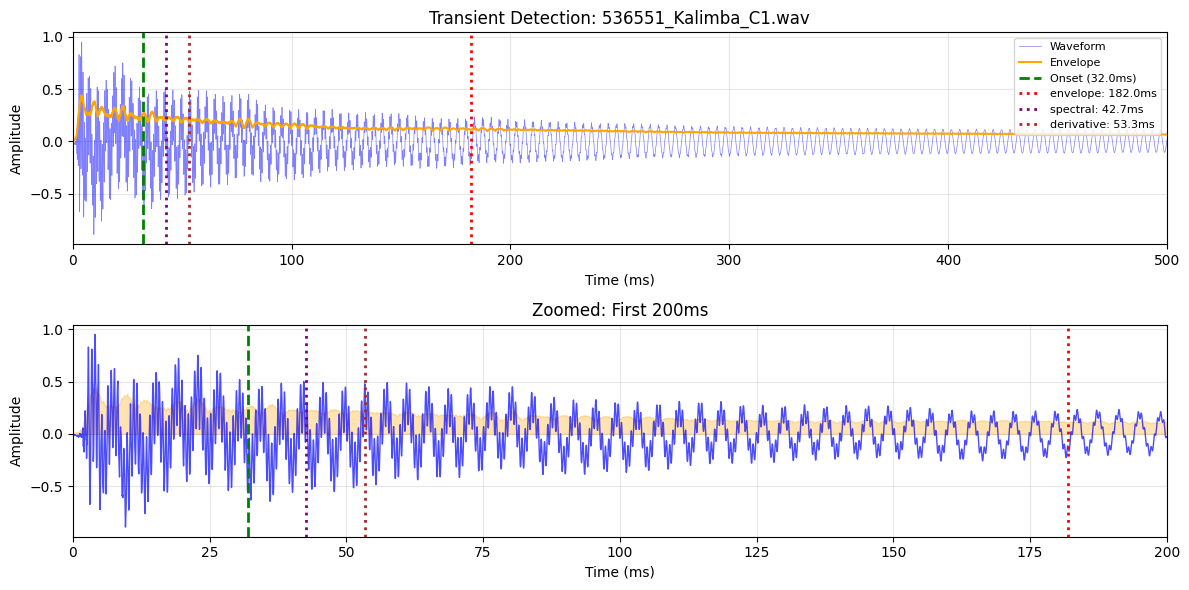


📐 Transient end points:
   envelope    : 182.0 ms
   spectral    : 42.7 ms
   derivative  : 53.3 ms


In [63]:
# ============================================================================
# VISUALIZE: Transient extraction and hybrid blend
# ============================================================================
import matplotlib.pyplot as plt

def visualize_transient_extraction(audio_path: Path, sr: int = 48000):
    """Visualize the transient detection on a sample."""
    
    y, _ = librosa.load(audio_path, sr=sr, mono=True)
    
    # Find onset
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='samples')
    onset_sample = onset_frames[0] if len(onset_frames) > 0 else 0
    
    # Find transient end using each method
    methods = ['envelope', 'spectral', 'derivative']
    ends = {}
    for method in methods:
        ends[method] = analyze_transient_end(y, sr, onset_sample, method=method, 
                                              decay_threshold=0.3, min_ms=5, max_ms=150)
    
    # Create envelope for display
    envelope = np.abs(y)
    window = max(1, int(0.002 * sr))
    envelope_smooth = uniform_filter1d(envelope, size=window)
    
    # Time axis
    t = np.arange(len(y)) / sr * 1000  # in ms
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # Waveform
    ax1 = axes[0]
    ax1.plot(t, y, 'b-', alpha=0.5, linewidth=0.5, label='Waveform')
    ax1.plot(t, envelope_smooth, 'orange', linewidth=1.5, label='Envelope')
    
    # Mark onset
    ax1.axvline(onset_sample / sr * 1000, color='green', linestyle='--', 
                linewidth=2, label=f'Onset ({onset_sample/sr*1000:.1f}ms)')
    
    # Mark transient ends
    colors = {'envelope': 'red', 'spectral': 'purple', 'derivative': 'brown'}
    for method, end_sample in ends.items():
        ax1.axvline(end_sample / sr * 1000, color=colors[method], 
                    linestyle=':', linewidth=2, label=f'{method}: {end_sample/sr*1000:.1f}ms')
    
    ax1.set_xlim(0, min(500, t[-1]))  # First 500ms
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'Transient Detection: {audio_path.name}')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Zoomed view of transient
    ax2 = axes[1]
    zoom_end = int(0.2 * sr)  # First 200ms
    t_zoom = t[:zoom_end]
    ax2.plot(t_zoom, y[:zoom_end], 'b-', alpha=0.7, linewidth=1)
    ax2.fill_between(t_zoom, 0, envelope_smooth[:zoom_end], alpha=0.3, color='orange')
    
    for method, end_sample in ends.items():
        if end_sample < zoom_end:
            ax2.axvline(end_sample / sr * 1000, color=colors[method], 
                        linestyle=':', linewidth=2)
    
    ax2.axvline(onset_sample / sr * 1000, color='green', linestyle='--', linewidth=2)
    ax2.set_xlim(0, 200)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Zoomed: First 200ms')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ends


# Visualize a kalimba sample
if kalimba_map:
    # Get first sample
    first_midi = sorted(kalimba_map.keys())[0]
    sample_info = kalimba_map[first_midi]
    
    full_path = sample_info.get('full_file')
    if full_path and full_path.exists():
        print(f"📊 Analyzing: {full_path.name}")
        print(f"   Note: {sample_info['note']}")
        print()
        ends = visualize_transient_extraction(full_path, TARGET_SR)
        
        print("\n📐 Transient end points:")
        for method, end_sample in ends.items():
            print(f"   {method:12}: {end_sample/TARGET_SR*1000:.1f} ms")
    else:
        print("⚠️ No full sample files found. Run the download cell with IMPROVED_QUERIES.")

In [64]:
# ============================================================================
# ANALYZE: What makes the B4 sample better?
# ============================================================================

print("=== Sample Quality Analysis ===\n")

# Check all samples in the map
for midi, info in sorted(kalimba_map.items()):
    note = info['note']
    full_file = info.get('full_file')
    
    if full_file and Path(full_file).exists():
        # Load sample
        audio, _ = librosa.load(full_file, sr=TARGET_SR, mono=True)
        
        # Analyze characteristics
        duration_ms = len(audio) / TARGET_SR * 1000
        peak_amp = np.max(np.abs(audio))
        
        # Extract exciter (50ms)
        exciter = audio[:int(0.05 * TARGET_SR)]
        exciter_energy = np.sqrt(np.mean(exciter**2))
        
        # Check attack sharpness (peak in first 5ms vs first 50ms)
        attack_5ms = audio[:int(0.005 * TARGET_SR)]
        attack_50ms = audio[:int(0.05 * TARGET_SR)]
        attack_sharpness = np.max(np.abs(attack_5ms)) / (np.max(np.abs(attack_50ms)) + 1e-10)
        
        # Spectral centroid (brightness)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=TARGET_SR)[0]
        avg_brightness = np.mean(spectral_centroid)
        
        print(f"{note:4s} (MIDI {midi:2d}): {duration_ms:6.0f}ms | "
              f"peak={peak_amp:.2f} | attack_sharp={attack_sharpness:.2f} | "
              f"brightness={avg_brightness:.0f}Hz")

print("\n=== B4 is good because... ===")
if 71 in kalimba_map:  # B4 = MIDI 71
    b4 = kalimba_map[71]
    print(f"B4 sample: {Path(b4['full_file']).name}")
    print("- Small shift needed (+1 to get C5)")
    print("- Check if it has a clean, sharp attack")
    print("- Higher notes often have cleaner transients (less low-freq mud)")
else:
    print("B4 not in sample map - checking what's available...")

=== Sample Quality Analysis ===

C1   (MIDI 24):   2539ms | peak=0.95 | attack_sharp=1.00 | brightness=1224Hz
C2   (MIDI 36):   2269ms | peak=0.95 | attack_sharp=0.01 | brightness=2994Hz
C3   (MIDI 48):    784ms | peak=0.95 | attack_sharp=0.66 | brightness=2427Hz
D3   (MIDI 50):   2500ms | peak=0.95 | attack_sharp=1.00 | brightness=1441Hz
A3   (MIDI 57):   4412ms | peak=0.95 | attack_sharp=0.75 | brightness=3687Hz
B3   (MIDI 59):   4048ms | peak=0.95 | attack_sharp=0.79 | brightness=3521Hz
G4   (MIDI 67):   1441ms | peak=0.95 | attack_sharp=1.00 | brightness=1343Hz
A4   (MIDI 69):   3887ms | peak=0.95 | attack_sharp=0.03 | brightness=4102Hz
B4   (MIDI 71):   5109ms | peak=0.95 | attack_sharp=0.00 | brightness=4698Hz
D5   (MIDI 74):   3994ms | peak=0.95 | attack_sharp=0.00 | brightness=4774Hz
E5   (MIDI 76):   4029ms | peak=0.95 | attack_sharp=0.69 | brightness=5195Hz
G5   (MIDI 79):   3136ms | peak=0.95 | attack_sharp=0.00 | brightness=5196Hz

=== B4 is good because... ===
B4 sample: 4